<a href="https://colab.research.google.com/github/tirth1/medX/blob/main/Brain_Tumor_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMG_PATH = '/content/gdrive/My Drive/brain tumor/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 143.58it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 25.52it/s]

50 images loaded from VAL/ directory.


In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

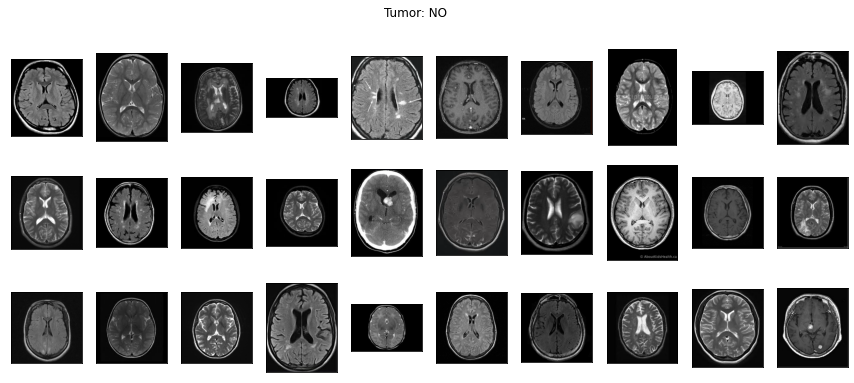

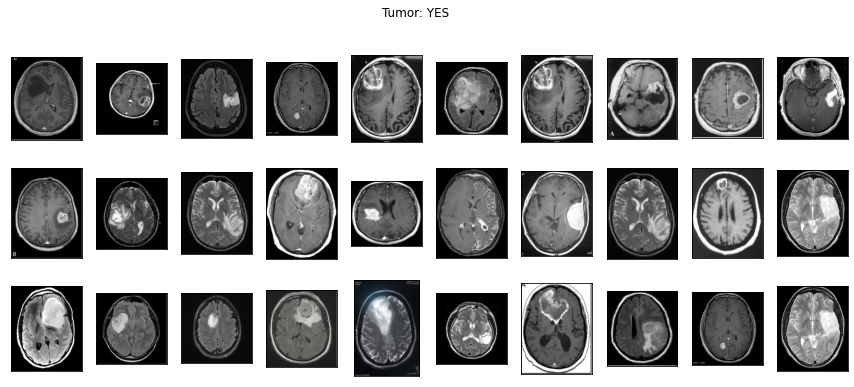

In [ ]:
plot_samples(X_train, y_train, labels, 30)

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



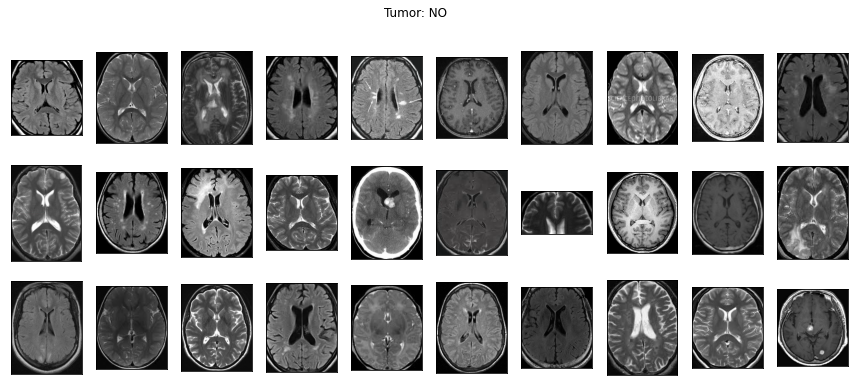

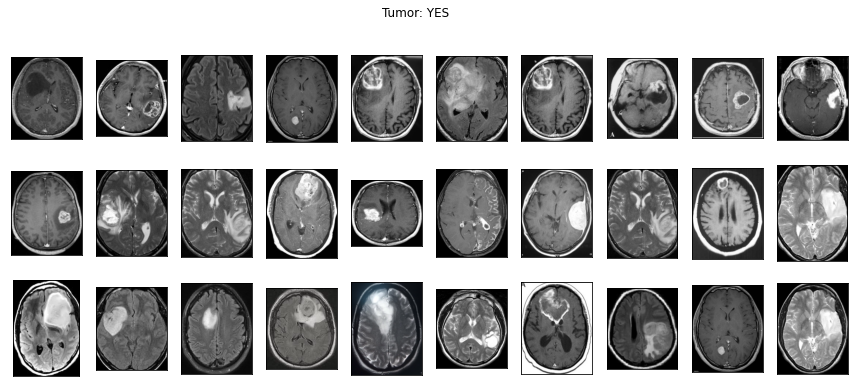

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
input_t = (224, 224, 3)
inception_v3_weight_path = '/content/gdrive/My Drive/pretrain-model-weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model_inception_v3 = InceptionV3(
    weights=inception_v3_weight_path,
    include_top=False, 
    input_shape= input_t
)

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model_inception_v3)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 24s 4s/step - loss: 0.4376 - accuracy: 0.8031 - val_loss: 0.2712 - val_accuracy: 0.8600
Epoch 2/30
6/6 [==============================] - 24s 4s/step - loss: 0.4500 - accuracy: 0.8238 - val_loss: 0.2937 - val_accuracy: 0.8800
Epoch 3/30
6/6 [==============================] - 24s 4s/step - loss: 0.5203 - accuracy: 0.7979 - val_loss: 0.2908 - val_accuracy: 0.8600
Epoch 4/30
6/6 [==============================] - 25s 4s/step - loss: 0.4874 - accuracy: 0.8290 - val_loss: 0.2761 - val_accuracy: 0.8600
Epoch 5/30
6/6 [==============================] - 24s 4s/step - loss: 0.4282 - accuracy: 0.8238 - val_loss: 0.2647 - val_accuracy: 0.8600
Epoch 6/30
6/6 [==============================] - 24s 4s/step - loss: 0.4470 - accuracy: 0.8187 - val_loss: 0.2494 - val_accuracy: 0.9000
Epoch 7/30
6/6 [==============================] - 24s 4s/step - loss: 0.3734 - accuracy: 0.8290 - val_loss: 0.2912 - val_accuracy: 0.8200
Epoch 8/30
6/6 [==================

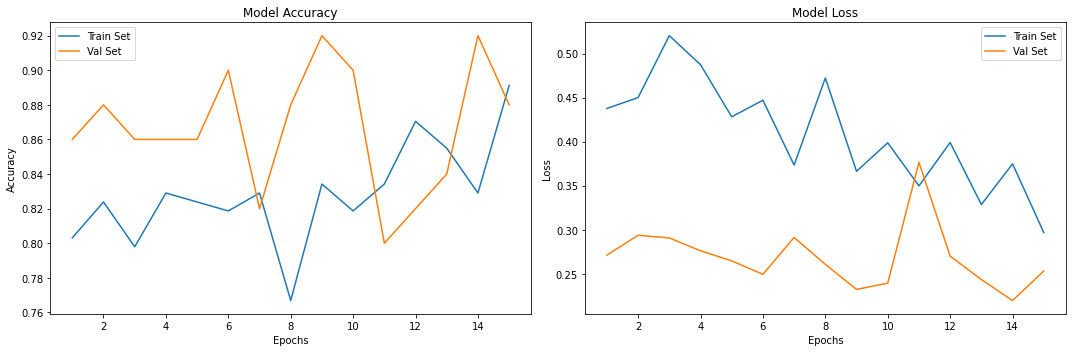

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.92


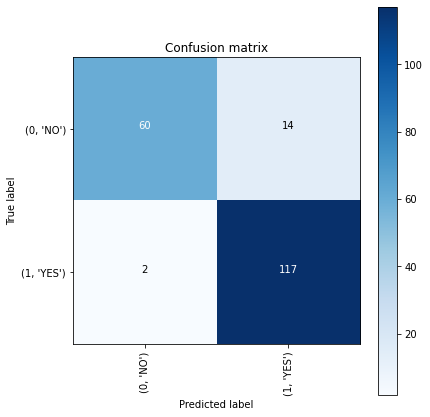

In [ ]:
# validate on train set
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.88


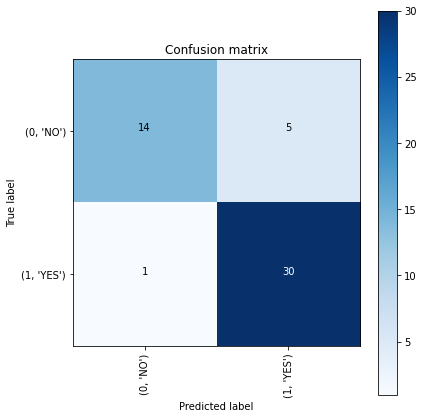

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.90


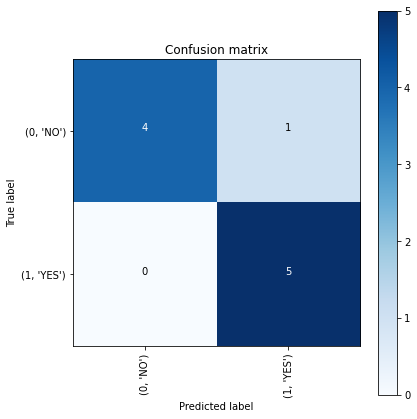

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
input_t = (224, 224, 3)
base_model_inception_v3 = InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape= input_t
)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model_inception_v3)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 25s 4s/step - loss: 0.8919 - accuracy: 0.6010 - val_loss: 0.8047 - val_accuracy: 0.6200
Epoch 2/30
6/6 [==============================] - 20s 3s/step - loss: 0.9202 - accuracy: 0.6114 - val_loss: 0.4870 - val_accuracy: 0.8200
Epoch 3/30
6/6 [==============================] - 20s 3s/step - loss: 0.6436 - accuracy: 0.6839 - val_loss: 0.4172 - val_accuracy: 0.8600
Epoch 4/30
6/6 [==============================] - 20s 3s/step - loss: 0.5879 - accuracy: 0.7150 - val_loss: 0.7521 - val_accuracy: 0.6400
Epoch 5/30
6/6 [==============================] - 20s 3s/step - loss: 0.6777 - accuracy: 0.6943 - val_loss: 0.3816 - val_accuracy: 0.8800
Epoch 6/30
6/6 [==============================] - 20s 3s/step - loss: 0.4910 - accuracy: 0.7824 - val_loss: 0.3557 - val_accuracy: 0.8600
Epoch 7/30
6/6 [==============================] - 20s 3s/step - loss: 0.4938 - accuracy: 0.7979 - val_loss: 0.6212 - val_accuracy: 0.6800
Epoch 8/30
6/6 [==================

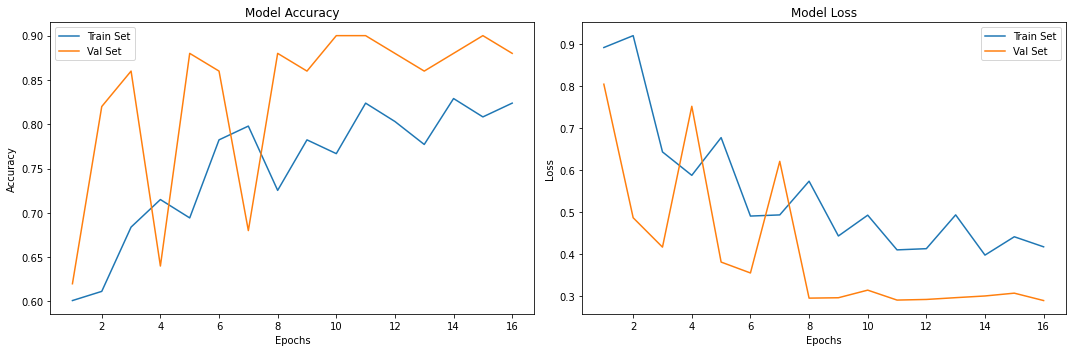

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.92


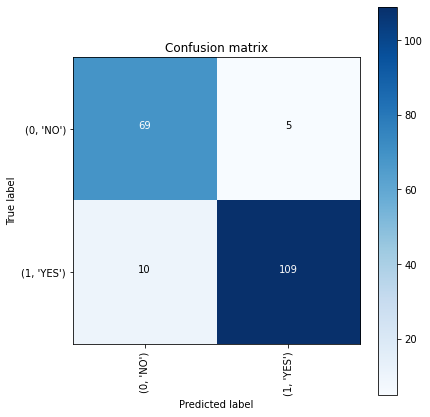

In [ ]:
# validate on train set
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.84


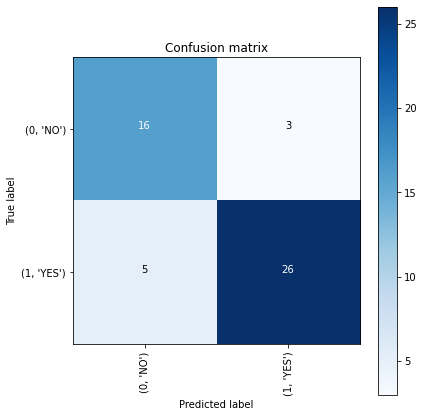

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


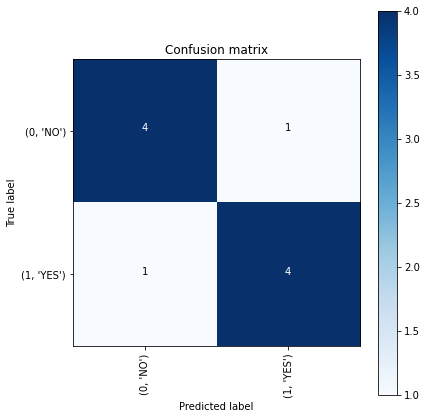

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)